<a href="https://colab.research.google.com/github/Sauman9456/peoplegrove/blob/main/peoplegrove_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1b7ixRJv3OQ2bk_-rYOqBUYmT94DwyYIc' -O pg_recommendation_data.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ZtZTaUGvPE7aLo28_SQJ1KqhjyrHd1e3' -O pg2.csv

!pip install sentence_transformers

--2021-09-05 10:47:13--  https://docs.google.com/uc?export=download&id=1b7ixRJv3OQ2bk_-rYOqBUYmT94DwyYIc
Resolving docs.google.com (docs.google.com)... 142.250.101.139, 142.250.101.138, 142.250.101.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.101.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3konstge7r52e2lump1qooeiosq2uch9/1630838775000/11293808022331717198/*/1b7ixRJv3OQ2bk_-rYOqBUYmT94DwyYIc?e=download [following]
--2021-09-05 10:47:15--  https://doc-0k-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3konstge7r52e2lump1qooeiosq2uch9/1630838775000/11293808022331717198/*/1b7ixRJv3OQ2bk_-rYOqBUYmT94DwyYIc?e=download
Resolving doc-0k-a0-docs.googleusercontent.com (doc-0k-a0-docs.googleusercontent.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to doc-0k-a0-docs.googleusercontent.com (doc-0k-a

In [1]:
from collections import Counter
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm
import sys
import numpy as np
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
pg_recommendation_data = pd.read_csv("pg_recommendation_data.csv")
cols = ['mentee_major', 'mentee_help_topics', 'mentee_experitse','mentor_major', 'mentor_help_topics', 'mentor_experitse']

In [43]:
df = pg_recommendation_data.copy()
df = df.apply(lambda x: x.astype(str).str.lower())
for i in cols:
  df[i] =  df[i].apply(lambda x: x.replace('[','').replace(']',''))
  df[i] = df[i].apply(lambda x: x.replace("'", ""))
  temp = i
  exec("%s = %s" % (temp,df[i].tolist()))
df

,mentee_major,mentee_help_topics,mentee_experitse,mentor_major,mentor_help_topics,mentor_experitse,final_match
0,accounting and financial management,"life skills, cover letter review, career plann...",accounting,accounting and financial management,"parenting vs. career, career / industry trends","finance, accounting",1
1,information systems management,"working overseas, life skills, startups, caree...","food & restaurants, law, computer - it service...","information systems management, project manage...","leadership skills, working overseas, personal ...","trade (wholesale), government / public admin, ...",0
2,"cybersecurity technology, computer networks an...","leadership skills, personal and professional d...","military & defense, technology, computer - it ...","cybersecurity technology, computer networks an...","management, resume / cv review, career / indus...","government / public admin, computer - it servi...",1
3,masters of human resources management,,human resources,business administration,"leadership skills, life skills, interviewing t...","human resources, advertising / marketing, tele...",0
4,sociology,"leadership skills, life skills, management, ca...",healthcare,business administration,"leadership skills, working overseas, personal ...","human resources, computer - hardware, finance,...",0
...,...,...,...,...,...,...,...
48877,communications,,"government / public admin, business services, ...",business administration,"leadership skills, life skills, management, wo...","sports & recreation, education, entertainment,...",0
48878,business administrsation,"interviewing tips, job search strategies, resu...","business services, consulting, transportation,...",finance,,international affairs & development,1
48879,"high school, management studies, general studies","leadership skills, life skills, management, ca...","non-profit / philanthropy, government / public...",management studies,,,1
48880,environmental management,"general networking, career change advice, netw...","environment, energy",environmental management,"leadership skills, working overseas, life skil...","entertainment, energy, international affairs &...",0


# EDA

In [171]:
def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

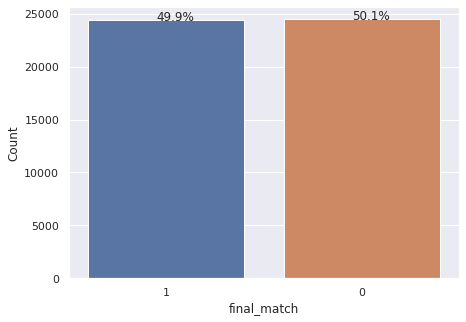

In [172]:
plt.figure(figsize=(7,5))
ax = sns.countplot(data=df, x='final_match',)
plt.xlabel('final_match', size = 12)
plt.ylabel('Count', size = 12)

without_hue(ax, df.final_match)

**Note: From the above graph we can see that, Given dataset is balanced. So we will use Accuracy as our evaluation matrix**

In [44]:
mentee_skill_major = []
mentor_skill_major = []
for i in range(len(mentee_major)):
  result = [x.strip() for x in mentee_major[i].split(',')]
  mentee_skill_major.extend(result)

for i in range(len(mentor_major)):
  result = [x.strip() for x in mentor_major[i].split(',')]
  mentor_skill_major.extend(result)

mentee_skill_help_topics = []
mentor_skill_help_topics = []
for i in range(len(mentee_help_topics)):
  result = [x.strip() for x in mentee_help_topics[i].split(',')]
  mentee_skill_help_topics.extend(result)

for i in range(len(mentor_help_topics)):
  result = [x.strip() for x in mentor_help_topics[i].split(',')]
  mentor_skill_help_topics.extend(result)

mentee_skill_experitse = []
mentor_skill_experitse = []
for i in range(len(mentee_experitse)):
  result = [x.strip() for x in mentee_experitse[i].split(',')]
  mentee_skill_experitse.extend(result)

for i in range(len(mentor_experitse)):
  result = [x.strip() for x in mentor_experitse[i].split(',')]
  mentor_skill_experitse.extend(result)

mentee_skill_major_set = set(mentee_skill_major)
mentor_skill_major_set = set(mentor_skill_major)

mentee_skill_help_topics_set = set(mentee_skill_help_topics)
mentor_skill_help_topics_set = set(mentor_skill_help_topics)

mentee_skill_experitse_set = set(mentee_skill_experitse)
mentor_skill_experitse_set = set(mentor_skill_experitse)

mentee_skill_major_set = list(filter(None, mentee_skill_major_set))
mentor_skill_major_set = list(filter(None, mentor_skill_major_set))
mentee_skill_help_topics_set = list(filter(None, mentee_skill_help_topics_set))
mentor_skill_help_topics_set = list(filter(None, mentor_skill_help_topics_set))
mentee_skill_experitse_set = list(filter(None, mentee_skill_experitse_set))
mentor_skill_experitse_set = list(filter(None, mentor_skill_experitse_set))

print("mentee_skill_major:", len(mentee_skill_major),",  mentor_skill_major:", len(mentor_skill_major), ",  mentee_skill_major_set:", len(mentee_skill_major_set), "  and  mentor_skill_major_set:",len(mentor_skill_major_set))
print("mentee_skill_help_topics:", len(mentee_skill_help_topics),",  mentor_skill_help_topics:", len(mentor_skill_help_topics), ",  mentee_skill_help_topics_set:", len(mentee_skill_help_topics_set), "  and  mentor_skill_help_topics_set:",len(mentor_skill_help_topics_set))
print("mentee_skill_experitse:", len(mentee_skill_experitse),",  mentor_skill_experitse:", len(mentor_skill_experitse), ",  mentee_skill_experitse_set:", len(mentee_skill_experitse_set), "  and  mentor_skill_experitse_set:",len(mentor_skill_experitse_set))

mentee_skill_major: 76744 ,  mentor_skill_major: 95656 ,  mentee_skill_major_set: 3382   and  mentor_skill_major_set: 2570
mentee_skill_help_topics: 160926 ,  mentor_skill_help_topics: 258027 ,  mentee_skill_help_topics_set: 25   and  mentor_skill_help_topics_set: 25
mentee_skill_experitse: 201591 ,  mentor_skill_experitse: 529702 ,  mentee_skill_experitse_set: 60   and  mentor_skill_experitse_set: 60


Text(0.5, 1.0, 'Mentee_skill_major')

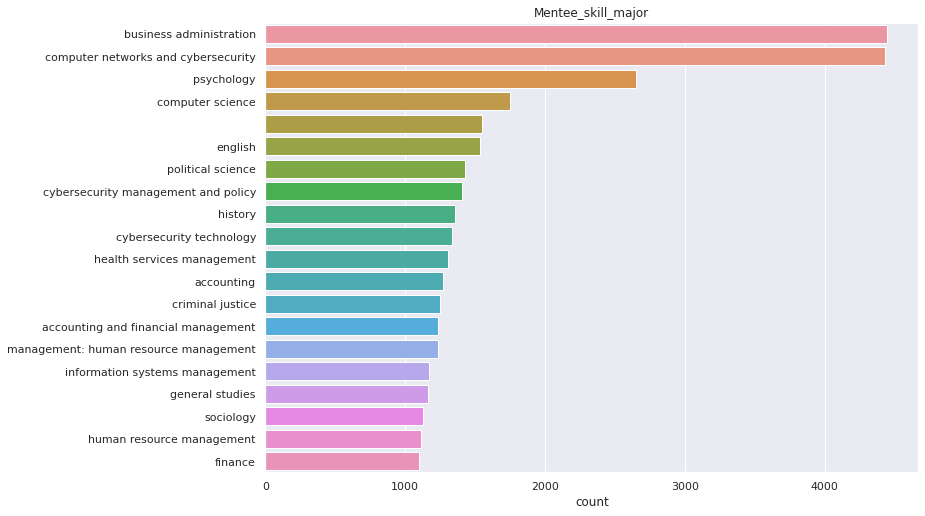

In [45]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(y = mentee_skill_major, order=pd.value_counts(mentee_skill_major).iloc[:20].index).set_title('Mentee_skill_major')

Text(0.5, 1.0, 'Mentor_skill_major')

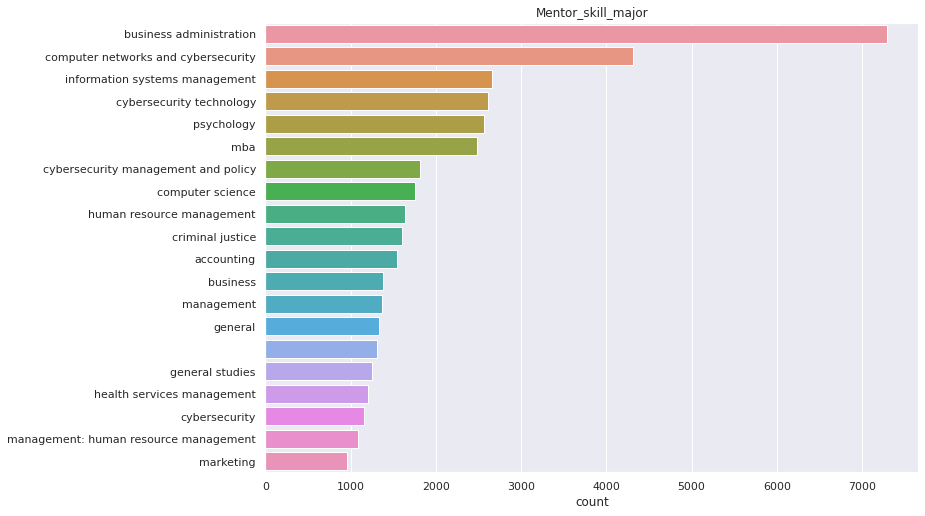

In [46]:
sns.countplot(y = mentor_skill_major, order=pd.value_counts(mentor_skill_major).iloc[:20].index).set_title('Mentor_skill_major')

Text(0.5, 1.0, 'Mentee_skill_help_topics')

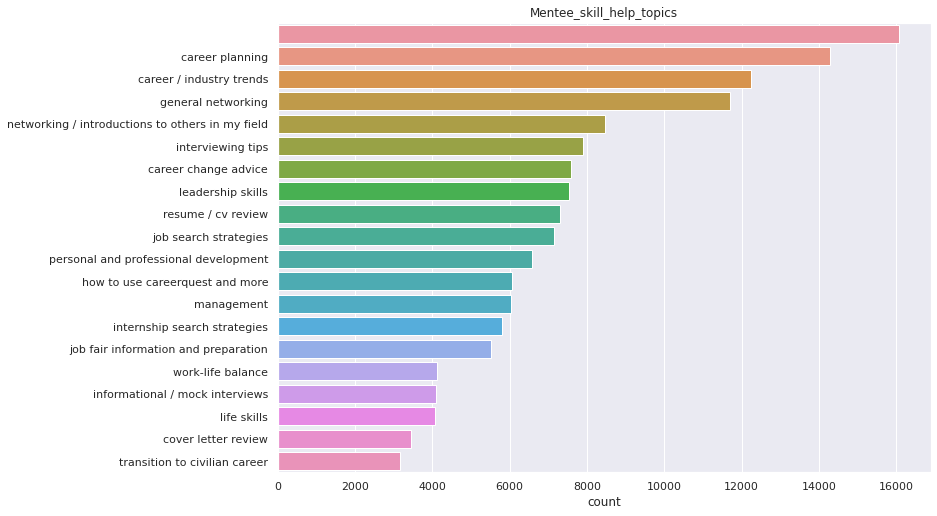

In [47]:
sns.countplot(y = mentee_skill_help_topics, order=pd.value_counts(mentee_skill_help_topics).iloc[:20].index).set_title('Mentee_skill_help_topics')

Text(0.5, 1.0, 'Mentor_skill_help_topics')

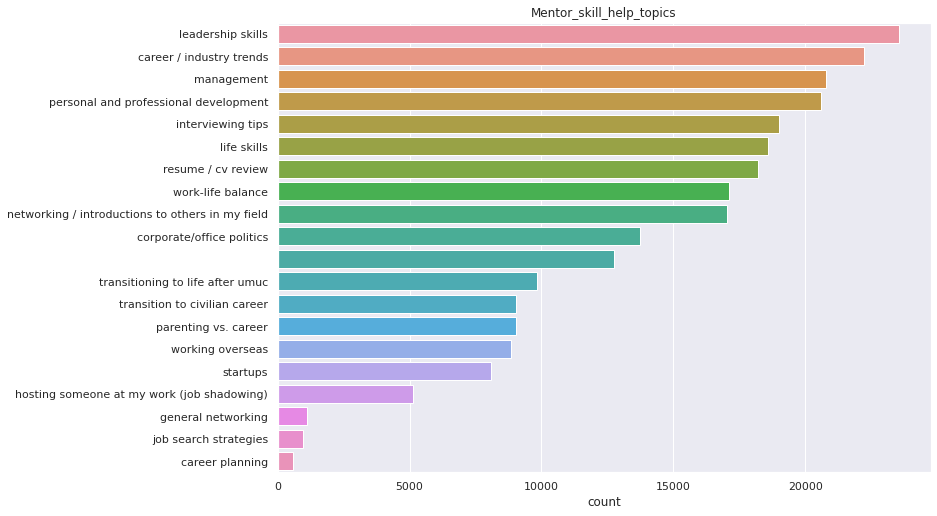

In [48]:
sns.countplot(y = mentor_skill_help_topics, order=pd.value_counts(mentor_skill_help_topics).iloc[:20].index).set_title('Mentor_skill_help_topics')

Text(0.5, 1.0, 'Mentee_skill_experitse')

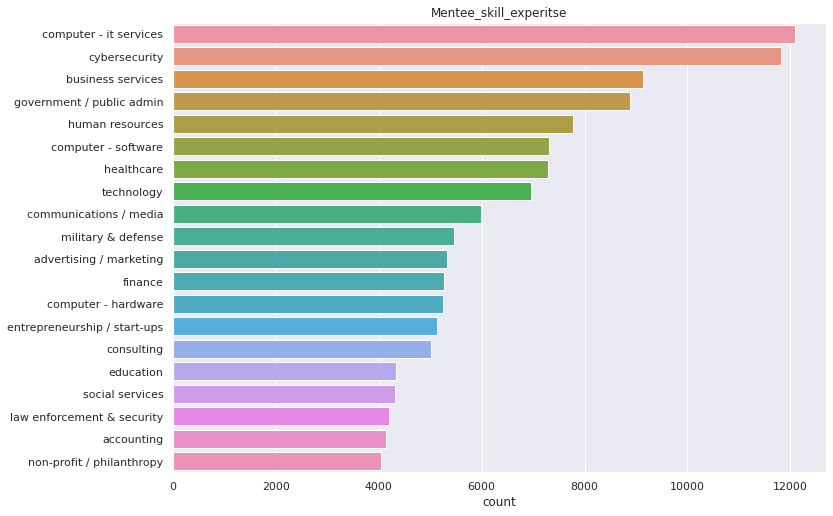

In [49]:
sns.countplot(y = mentee_skill_experitse, order=pd.value_counts(mentee_skill_experitse).iloc[:20].index).set_title('Mentee_skill_experitse')

Text(0.5, 1.0, 'Mentor_skill_experitse')

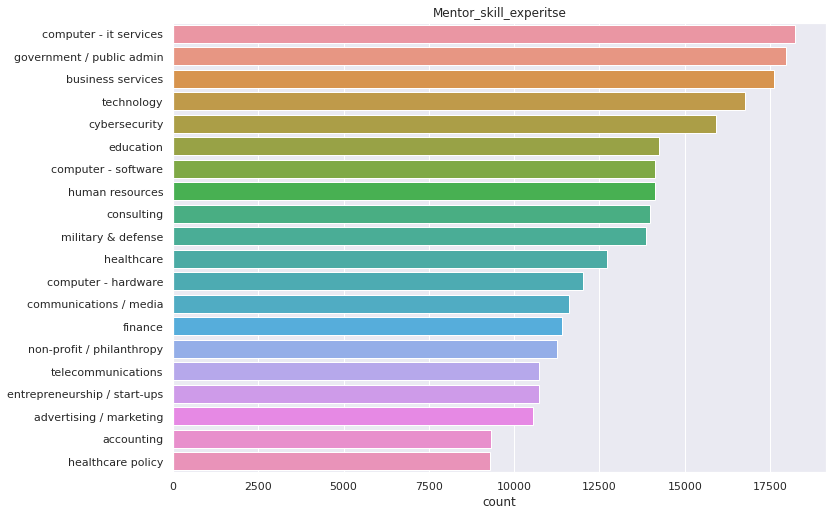

In [50]:
sns.countplot(y = mentor_skill_experitse, order=pd.value_counts(mentor_skill_experitse).iloc[:20].index).set_title('Mentor_skill_experitse')

# Method_1: Using Word Mover’s Distance

## Pre_processing: Removing Stop words, Square brackets, single quotes, Converting into lowercase

In [51]:
df = pg_recommendation_data.copy()
df = df.apply(lambda x: x.astype(str).str.lower())
for i in cols:
  df[i] = df[i].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
  df[i] =  df[i].apply(lambda x: x.replace('[','').replace(']',''))
  df[i] = df[i].apply(lambda x: x.replace("'", ""))
  temp = i
  exec("%s = %s" % (temp,df[i].tolist()))
df

,mentee_major,mentee_help_topics,mentee_experitse,mentor_major,mentor_help_topics,mentor_experitse,final_match
0,accounting financial management,"life skills, cover letter review, career plann...",accounting,accounting financial management,"parenting vs. career, career / industry trends","finance, accounting",1
1,information systems management,"working overseas, life skills, startups, caree...","food & restaurants, law, computer - services, ...","information systems management, project manage...","leadership skills, working overseas, personal ...","trade (wholesale), government / public admin, ...",0
2,"cybersecurity technology, computer networks cy...","leadership skills, personal professional devel...","military & defense, technology, computer - ser...","cybersecurity technology, computer networks cy...","management, resume / cv review, career / indus...","government / public admin, computer - services...",1
3,masters human resources management,,human resources,business administration,"leadership skills, life skills, interviewing t...","human resources, advertising / marketing, tele...",0
4,sociology,"leadership skills, life skills, management, ca...",healthcare,business administration,"leadership skills, working overseas, personal ...","human resources, computer - hardware, finance,...",0
...,...,...,...,...,...,...,...
48877,communications,,"government / public admin, business services, ...",business administration,"leadership skills, life skills, management, wo...","sports & recreation, education, entertainment,...",0
48878,business administrsation,"interviewing tips, job search strategies, resu...","business services, consulting, transportation,...",finance,,international affairs & development,1
48879,"high school, management studies, general studies","leadership skills, life skills, management, ca...","non-profit / philanthropy, government / public...",management studies,,,1
48880,environmental management,"general networking, career change advice, netw...","environment, energy",environmental management,"leadership skills, working overseas, life skil...","entertainment, energy, international affairs &...",0


## Creating Vocabulary from given dataset and adding it to Word2vec models

In [52]:
skill_major = []
for i in range(len(mentee_major)):
  result = [x.strip() for x in mentee_major[i].split(' ')]
  skill_major.append(result)

for i in range(len(mentor_major)):
  result = [x.strip() for x in mentor_major[i].split(' ')]
  skill_major.append(result)

skill_help_topics = []

for i in range(len(mentee_help_topics)):
  result = [x.strip() for x in mentee_help_topics[i].split(' ')]
  skill_help_topics.append(result)

for i in range(len(mentor_help_topics)):
  result = [x.strip() for x in mentor_help_topics[i].split(' ')]
  skill_help_topics.append(result)

skill_experitse = []

for i in range(len(mentee_experitse)):
  result = [x.strip() for x in mentee_experitse[i].split(' ')]
  skill_experitse.append(result)

for i in range(len(mentor_experitse)):
  result = [x.strip() for x in mentor_experitse[i].split(' ')]
  skill_experitse.append(result)

#skill_set_major = set(skill_major)

#skill_set_help_topics = set(skill_help_topics)

#skill_set_experitse = set(skill_experitse)

print("skill_major:", len(skill_major),"  and  skill_set_major:",len(skill_set_major))
print("skill_help_topics:", len(skill_help_topics),"  and  skill_set_help_topics:",len(skill_set_help_topics))
print("skill_experitse:", len(skill_experitse),"  and  skill_set_experitse:",len(skill_set_experitse))

skill_major: 97764   and  skill_set_major: 5533
skill_help_topics: 97764   and  skill_set_help_topics: 25
skill_experitse: 97764   and  skill_set_experitse: 60


In [53]:
model_major = Word2Vec(skill_major)
model_help_topics = Word2Vec(skill_help_topics)
model_experitse = Word2Vec(skill_experitse)

## Feature Engineering: Getting the similarity Score between mentee & mentor
Converting 'mentee_major', 'mentee_help_topics', 'mentee_experitse',   'mentor_major', 'mentor_help_topics', 'mentor_experitse'

Into their similarity score using Using Word Mover’s Distance 

In [55]:
major = []
help_topics = []
experitse = []
entity_major = df['mentee_major'].astype(str)
target_major = df['mentor_major'].astype(str)
entity_help_topics = df['mentee_help_topics'].astype(str)
target_help_topics = df['mentor_help_topics'].astype(str)
entity_experitse = df['mentee_experitse'].astype(str)
target_experitse = df['mentor_experitse'].astype(str)

for i,j,k,l,m,n in tqdm(zip(entity_major,target_major, entity_help_topics, target_help_topics, entity_experitse, target_experitse)):
    t = []
    result = [x.strip() for x in i.split(' ')]
    t.extend(result)
    pt = []
    result = [x.strip() for x in j.split(' ')]
    pt.extend(result)
    wmd_distance = model_major.wv.wmdistance(t, pt)
    major.append(wmd_distance)

    t = []
    result = [x.strip() for x in k.split(' ')]
    t.extend(result)
    pt = []
    result = [x.strip() for x in l.split(' ')]
    pt.extend(result)
    wmd_distance = model_help_topics.wv.wmdistance(t, pt)
    help_topics.append(wmd_distance)

    t = []
    result = [x.strip() for x in m.split(' ')]
    t.extend(result)
    pt = []
    result = [x.strip() for x in n.split(' ')]
    pt.extend(result)
    wmd_distance = model_experitse.wv.wmdistance(t, pt)
    experitse.append(wmd_distance)

48882it [05:11, 157.01it/s]


In [56]:
df['major'] = major
df['help_topics'] = help_topics
df['experitse'] = experitse

## Handling the Infinity values

In [57]:
c = np.isinf(df['major']).values.sum()
print("major contains " + str(c) + " infinite values")

c = np.isinf(df['help_topics']).values.sum()
print("help_topics contains " + str(c) + " infinite values")

c = np.isinf(df['experitse']).values.sum()
print("experitse contains " + str(c) + " infinite values")

major contains 205 infinite values
help_topics contains 0 infinite values
experitse contains 0 infinite values


In [58]:
df['major'] = df['major'].replace(-np.inf, 20)
df['major'] = df['major'].replace(np.inf, 20)

In [59]:
df.to_csv("pg.csv", index= False)

## Multicollinearity check

In [62]:
df_x = df.copy()
df_x['final_match'] = df_x['final_match'].astype(int)

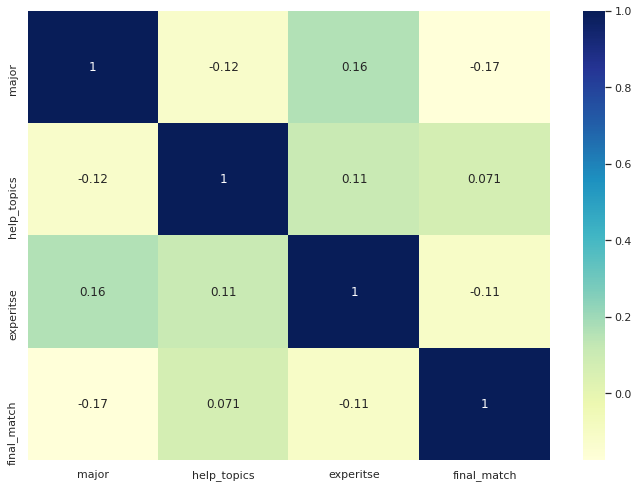

In [68]:
dataplot = sns.heatmap(df_x[['major', 'help_topics', 'experitse','final_match']].corr(method = "spearman"), cmap="YlGnBu", annot=True)
plt.show()

## Model selection via cross validation

In [69]:
X = df[['major', 'help_topics', 'experitse']]
y = df['final_match']

import warnings
warnings.filterwarnings('ignore')
pipelines = []
pipelines.append(('LR', Pipeline([('LR', LogisticRegression())])))
pipelines.append(('RF', Pipeline([('RF', RandomForestClassifier())])))
pipelines.append(('EXT', Pipeline([('EXT', ExtraTreesClassifier())])))
pipelines.append(('ScaledGBM', Pipeline([('GBM', GradientBoostingClassifier())])))
pipelines.append(('XGB', Pipeline([('XGB', XGBClassifier(n_estimators = 2000))])))
pipelines.append(('LGBM', Pipeline([('LGBM', LGBMClassifier(n_estimators= 1000))])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f" % (name, cv_results.mean())
    print(msg)
    print(cv_results)
    print("")

LR: 0.590463
[0.5784414  0.59521375 0.58776596 0.59451718 0.5861293  0.59860884
 0.59001637 0.60106383 0.59288052 0.57999182]

RF: 0.639111
[0.62814481 0.64205359 0.63625205 0.64218494 0.64566285 0.63522913
 0.6438216  0.63522913 0.64607201 0.63645663]

EXT: 0.630601
[0.61812232 0.62896298 0.63195581 0.63502455 0.63359247 0.62090835
 0.63297872 0.6297054  0.63972995 0.63502455]

ScaledGBM: 0.639622
[0.63121293 0.64389446 0.6344108  0.64300327 0.6391162  0.63870704
 0.64668576 0.6438216  0.64075286 0.63461538]

XGB: 0.667731
[0.6651667  0.66741665 0.66530278 0.66878069 0.67041735 0.6685761
 0.6710311  0.66796236 0.67225859 0.6603928 ]

LGBM: 0.647682
[0.64716711 0.65616691 0.65036825 0.6497545  0.63952537 0.63891162
 0.65425532 0.64279869 0.65732406 0.64054828]



# Method 2: Using pre_trained models(Hugging Face)

## Pre_processing: Removing Stop words, Square brackets, single quotes, Converting into lowercase

In [70]:
df2 = pg_recommendation_data.copy()
df2 = df2.apply(lambda x: x.astype(str).str.lower())
for i in cols:
  df2[i] = df2[i].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
  df2[i] =  df2[i].apply(lambda x: x.replace('[','').replace(']',''))
  df2[i] = df2[i].apply(lambda x: x.replace("'", ""))
  temp = i
  exec("%s = %s" % (temp,df2[i].tolist()))
df2

,mentee_major,mentee_help_topics,mentee_experitse,mentor_major,mentor_help_topics,mentor_experitse,final_match
0,accounting financial management,"life skills, cover letter review, career plann...",accounting,accounting financial management,"parenting vs. career, career / industry trends","finance, accounting",1
1,information systems management,"working overseas, life skills, startups, caree...","food & restaurants, law, computer - services, ...","information systems management, project manage...","leadership skills, working overseas, personal ...","trade (wholesale), government / public admin, ...",0
2,"cybersecurity technology, computer networks cy...","leadership skills, personal professional devel...","military & defense, technology, computer - ser...","cybersecurity technology, computer networks cy...","management, resume / cv review, career / indus...","government / public admin, computer - services...",1
3,masters human resources management,,human resources,business administration,"leadership skills, life skills, interviewing t...","human resources, advertising / marketing, tele...",0
4,sociology,"leadership skills, life skills, management, ca...",healthcare,business administration,"leadership skills, working overseas, personal ...","human resources, computer - hardware, finance,...",0
...,...,...,...,...,...,...,...
48877,communications,,"government / public admin, business services, ...",business administration,"leadership skills, life skills, management, wo...","sports & recreation, education, entertainment,...",0
48878,business administrsation,"interviewing tips, job search strategies, resu...","business services, consulting, transportation,...",finance,,international affairs & development,1
48879,"high school, management studies, general studies","leadership skills, life skills, management, ca...","non-profit / philanthropy, government / public...",management studies,,,1
48880,environmental management,"general networking, career change advice, netw...","environment, energy",environmental management,"leadership skills, working overseas, life skil...","entertainment, energy, international affairs &...",0


## Loading the pre_trained model

In [71]:
sbert_model = SentenceTransformer('all-mpnet-base-v2', device='cuda')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Feature Engineering: Embedding & Cosine similarity
Converting 'mentee_major', 'mentee_help_topics', 'mentee_experitse', 'mentor_major', 'mentor_help_topics', 'mentor_experitse'

Into their similarity score using Cosine similarity

**Note: With gpu this step will take 1-2 hours and without gpu this will take 13-16 hours. I have already added the processed file with name "pg2.csv" you can load that file and avoid this step.**

In [72]:
major2 = []
help_topics2 = []
experitse2 = []
entity_major = df2['mentee_major'].astype(str)
target_major = df2['mentor_major'].astype(str)
entity_help_topics = df2['mentee_help_topics'].astype(str)
target_help_topics = df2['mentor_help_topics'].astype(str)
entity_experitse = df2['mentee_experitse'].astype(str)
target_experitse = df2['mentor_experitse'].astype(str)


In [73]:
for i,j,k,l,m,n in tqdm(zip(entity_major,target_major, entity_help_topics, target_help_topics, entity_experitse, target_experitse)):
    t = []
    result = [x.strip() for x in i.split(',')]
    t.extend(result)
    pt = []
    result = [x.strip() for x in j.split(',')]
    pt.extend(result)
    t = sbert_model.encode(t)
    pt = sbert_model.encode(pt)
    wmd_distance = cosine_similarity(t,pt)
    dist = []
    for o in wmd_distance:
      dist.append(max(o))
    wmd_distance = np.mean(dist)
    #print(wmd_distance)
    major2.append(wmd_distance)

    t = []
    result = [x.strip() for x in k.split(',')]
    t.extend(result)
    pt = []
    result = [x.strip() for x in l.split(',')]
    pt.extend(result)
    t = sbert_model.encode(t)
    pt = sbert_model.encode(pt)
    wmd_distance = cosine_similarity(t,pt)
    dist = []
    for o in wmd_distance:
      dist.append(max(o))
    wmd_distance = np.mean(dist)
    #print(wmd_distance)
    help_topics2.append(wmd_distance)

    t = []
    result = [x.strip() for x in m.split(',')]
    t.extend(result)
    pt = []
    result = [x.strip() for x in n.split(',')]
    pt.extend(result)
    t = sbert_model.encode(t)
    pt = sbert_model.encode(pt)
    wmd_distance = cosine_similarity(t,pt)
    dist = []
    for o in wmd_distance:
      dist.append(max(o))
    wmd_distance = np.mean(dist)
    #print(wmd_distance)
    experitse2.append(wmd_distance)


48882it [1:03:09, 12.90it/s]


In [74]:
df2['major2'] = major2
df2['help_topics2'] = help_topics2
df2['experitse2'] = experitse2

## Handling the Infinity values

In [75]:
c = np.isinf(df2['major2']).values.sum()
print("major contains " + str(c) + " infinite values")

c = np.isinf(df2['help_topics2']).values.sum()
print("help_topics contains " + str(c) + " infinite values")

c = np.isinf(df2['experitse2']).values.sum()
print("experitse contains " + str(c) + " infinite values")

major contains 0 infinite values
help_topics contains 0 infinite values
experitse contains 0 infinite values


In [76]:
df2.to_csv("pg2.csv", index = False)

## Multicollinearity check

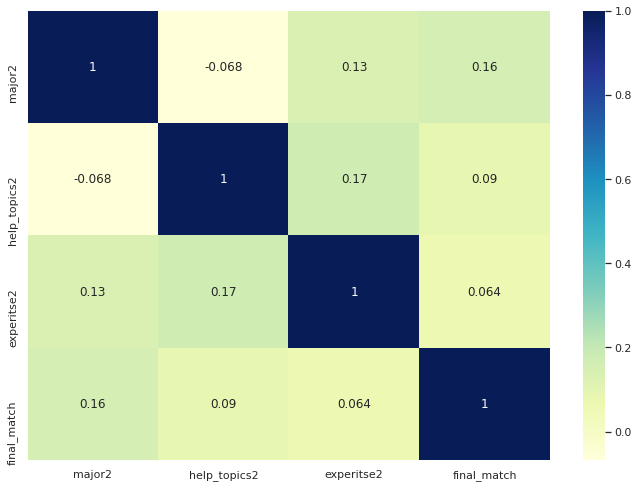

In [77]:
df_x = df2.copy()
df_x['final_match'] = df_x['final_match'].astype(int)
dataplot = sns.heatmap(df_x[['major2', 'help_topics2', 'experitse2','final_match']].corr(method = "spearman"), cmap="YlGnBu", annot=True)
plt.show()

## Model selection via cross validation

In [4]:
df3 = df2.copy()
df3 = pd.read_csv("pg2.csv")

In [5]:
X = df3[['major2', 'help_topics2', 'experitse2']]
y = df3['final_match']

In [85]:
import warnings
warnings.filterwarnings('ignore')
pipelines = []
pipelines.append(('LR', Pipeline([('LR', LogisticRegression())])))
pipelines.append(('RF', Pipeline([('RF', RandomForestClassifier())])))
pipelines.append(('EXT', Pipeline([('EXT', ExtraTreesClassifier())])))
pipelines.append(('ScaledGBM', Pipeline([('GBM', GradientBoostingClassifier())])))
pipelines.append(('XGB', Pipeline([('XGB', XGBClassifier(n_estimators = 100, tree_method = "gpu_hist"))])))
pipelines.append(('LGBM', Pipeline([('LGBM', LGBMClassifier(n_estimators=100, tree_method = "gpu_hist"))])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f" % (name, cv_results.mean())
    print(msg)
    print(cv_results)
    print("")

LR: 0.580582
[0.58314584 0.58314584 0.58265139 0.5814239  0.57324059 0.58653846
 0.57774141 0.58510638 0.5801964  0.57262684]

RF: 0.694693
[0.69727961 0.69462058 0.69251227 0.69496727 0.69558101 0.70090016
 0.69394435 0.68412439 0.70417349 0.68882979]

EXT: 0.675668
[0.68337083 0.67498466 0.65814239 0.67655483 0.67982815 0.68126023
 0.67246318 0.67021277 0.67982815 0.68003273]

ScaledGBM: 0.683339
[0.68152997 0.68500716 0.68207856 0.68576105 0.68207856 0.68698854
 0.68473813 0.67287234 0.69169394 0.68064648]

XGB: 0.687615
[0.68684803 0.69052976 0.67900982 0.69230769 0.68678396 0.69271686
 0.69517185 0.67880524 0.69333061 0.68064648]

LGBM: 0.701751
[0.70096134 0.70607486 0.70192308 0.70417349 0.69946809 0.7064239
 0.70887889 0.68698854 0.70417349 0.69844517]



**Note: Method 2 gives better performance. So we will use this method for Hyperparameter Tuning**

## Hyperparameter Tuning

### n_estimators

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
Model = XGBClassifier(n_estimators = 100, tree_method = "gpu_hist")
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)
score = accuracy_score(y_test,y_pred)
print("XGB: ",score)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
Model = LGBMClassifier(n_estimators = 100, tree_method = "gpu_hist")
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)
score = accuracy_score(y_test,y_pred)
print("LGBMClassifier: ",score)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
Model = RandomForestClassifier(n_estimators = 100)
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)
score = accuracy_score(y_test,y_pred)
print("RandomForestClassifier: ",score)

XGB:  0.7020558453513348
LGBMClassifier:  0.7145341106678941
RandomForestClassifier:  0.7057379564283522


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
accuracy_LGBM = []
Model = LGBMClassifier(warm_start = True, tree_method = "gpu_hist")
for i in [*range(1,300,1)]:
  Model.n_estimators = i
  Model.fit(X_train,y_train)
  y_pred = Model.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  accuracy_LGBM.append(accuracy)

Text(0, 0.5, 'Accuracy')

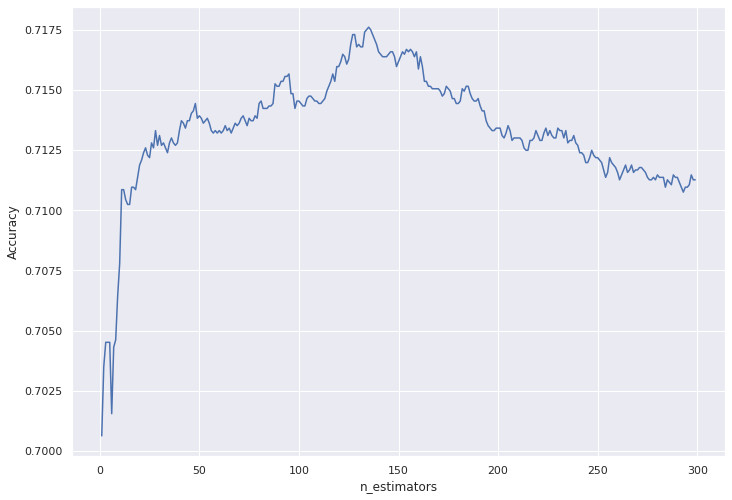

In [95]:
p = [*range(1,300,1)]
plt.plot(p, accuracy_LGBM)
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
Model = LGBMClassifier(n_estimators = 135, tree_method = "gpu_hist")
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)
score = accuracy_score(y_test,y_pred)
print("LGBMClassifier: ",score)

LGBMClassifier:  0.7176025365654086


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
accuracy_RF = []
Model = RandomForestClassifier(warm_start = True,)
for i in [*range(1,300,1)]:
  Model.n_estimators = i
  Model.fit(X_train,y_train)
  y_pred = Model.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  accuracy_RF.append(accuracy)
  print(i)
  print(accuracy)

Text(0, 0.5, 'Accuracy')

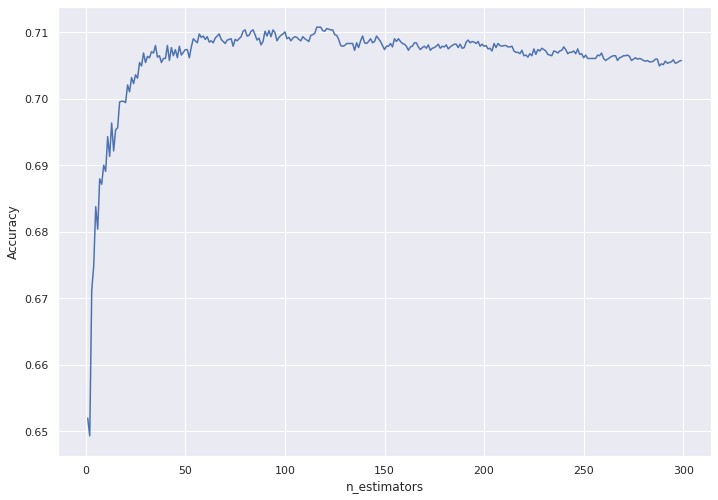

In [104]:
p = [*range(1,300,1)]
plt.plot(p, accuracy_RF)
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")

In [114]:
print("RandomForestClassifier", max(accuracy_RF))

RandomForestClassifier 0.710749718727626


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
accuracy_xgb = []
Model = XGBClassifier(warm_start = True, tree_method = "gpu_hist")
for i in [*range(100,600,1)]:
  Model.n_estimators = i
  Model.fit(X_train,y_train)
  y_pred = Model.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  accuracy_xgb.append(accuracy)

Text(0, 0.5, 'Accuracy')

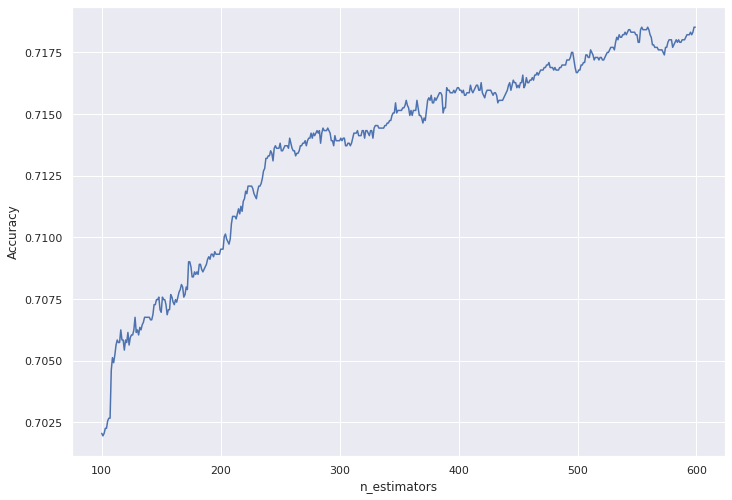

In [110]:
p = [*range(100,600,1)]
plt.plot(p, accuracy_xgb)
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
Model = XGBClassifier(n_estimators = 554, tree_method = "gpu_hist")
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)
score = accuracy_score(y_test,y_pred)
print("XGB: ",score)

XGB:  0.718523064334663


### Regularization

In [ ]:
reg = []
for i in range(1,100,1):
  i = i/100
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
  Model = XGBClassifier(n_estimators = 554, tree_method = "gpu_hist" ,max_depth=3, reg_alpha= i)
  Model.fit(X_train, y_train)
  y_pred = Model.predict(X_test)
  score = accuracy_score(y_test,y_pred)
  reg.append(score)

In [ ]:
reg2 = []
for i in range(1,101,1):
  i = i/100
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
  Model = XGBClassifier(n_estimators = 554, tree_method = "gpu_hist" ,max_depth=3, reg_alpha= 0.12, reg_lambda= i)
  Model.fit(X_train, y_train)
  y_pred = Model.predict(X_test)
  score = accuracy_score(y_test,y_pred)
  reg2.append(score)

In [126]:
max(reg2)

0.7189321877876649

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
Model = XGBClassifier(n_estimators = 554, tree_method = "gpu_hist", max_depth=3, reg_alpha= 0.12, reg_lambda = 1)
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)
score = accuracy_score(y_test,y_pred)
print("XGB: ",score)

XGB:  0.7194435921039174


In [ ]:
reg_LGBM = []
for i in range(1,100,1):
  i = i/100
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
  Model = LGBMClassifier(n_estimators = 135, tree_method = "gpu_hist" , reg_alpha= i )
  Model.fit(X_train, y_train)
  y_pred = Model.predict(X_test)
  score = accuracy_score(y_test,y_pred)
  reg_LGBM.append(score)

In [134]:
reg_LGBM2 = []
for i in range(1,100,1):
  i = i/100
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
  Model = LGBMClassifier(n_estimators = 135, tree_method = "gpu_hist" , reg_alpha= 0.15, reg_lambda= i )
  Model.fit(X_train, y_train)
  y_pred = Model.predict(X_test)
  score = accuracy_score(y_test,y_pred)
  reg_LGBM2.append(score)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
Model = LGBMClassifier(n_estimators = 135, tree_method = "gpu_hist", reg_alpha= 0.15, reg_lambda= 0.34)
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)
score = accuracy_score(y_test,y_pred)
print("LGBMClassifier: ",score)

LGBMClassifier:  0.7190344686509154


## Learning cureve for Overfitting and Underfitting

In [143]:
# learning cureve to identify overfitting and underfitting 
from sklearn.model_selection import learning_curve
train_sizes = [10000, 15000, 20000, 25000, 30000, 35000, 39105]
features = list(X.columns)

model = LGBMClassifier(n_estimators = 135, tree_method = "gpu_hist", reg_alpha= 0.15, reg_lambda= 0.34)

train_sizes, train_scores, validation_scores = learning_curve(
model, X[features], y, train_sizes =
train_sizes,cv = 5, scoring = 'accuracy')
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)




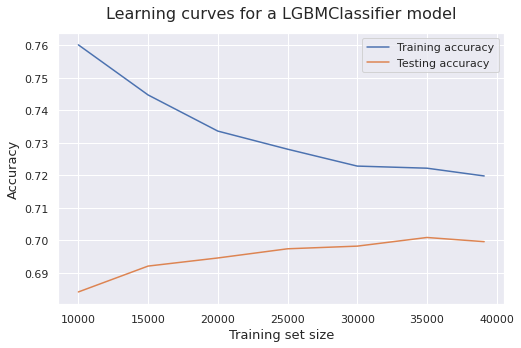

In [144]:
plt.figure(figsize = (8,5))
plt.plot(train_sizes, train_scores_mean, label = 'Training accuracy')
plt.plot(train_sizes, validation_scores_mean, label = 'Testing accuracy')

plt.ylabel('Accuracy', fontsize = 13)
plt.xlabel('Training set size', fontsize = 13)
title = 'Learning curves for a ' + str(Model).split('(')[0] + ' model'
plt.title(title, fontsize = 16, y = 1.03)
plt.legend()
plt.show()

In [140]:
# learning cureve to identify overfitting and underfitting 
from sklearn.model_selection import learning_curve
train_sizes = [10000, 15000, 20000, 25000, 30000, 35000, 39105]
features = list(X.columns)

model = XGBClassifier(n_estimators = 554, tree_method = "gpu_hist", max_depth=3, reg_alpha= 0.12, reg_lambda = 1)

train_sizes, train_scores, validation_scores = learning_curve(
model, X[features], y, train_sizes =
train_sizes,cv = 5, scoring = 'accuracy')
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)


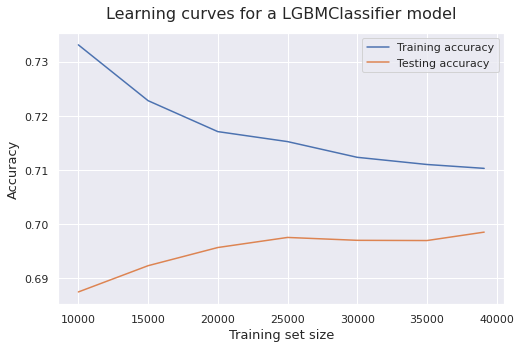

In [142]:
plt.figure(figsize = (8,5))
plt.plot(train_sizes, train_scores_mean, label = 'Training accuracy')
plt.plot(train_sizes, validation_scores_mean, label = 'Testing accuracy')

plt.ylabel('Accuracy', fontsize = 13)
plt.xlabel('Training set size', fontsize = 13)
title = 'Learning curves for a ' + str(Model).split('(')[0] + ' model'
plt.title(title, fontsize = 16, y = 1.03)
plt.legend()
plt.show()



1.   As training set size increases testing accuracy increases. Therefore adding more data will increase the perforamce
2.   Training accuracy is high, so our model has low baise
3.   Gap between the two curve indicates variance.Generally, the more narrow the gap, the lower the variance. The opposite is also true: the wider the gap, the greater the variance. here we have high variance
4.  This high variance problem can be solve by adding more data, as we can see that, in the garph slope of test accuracy is more then train accuracy
5.  Generally in low bias and high variance,  XGboost perform well



## Confusion_matrix

LGBMClassifier:  0.7190344686509154


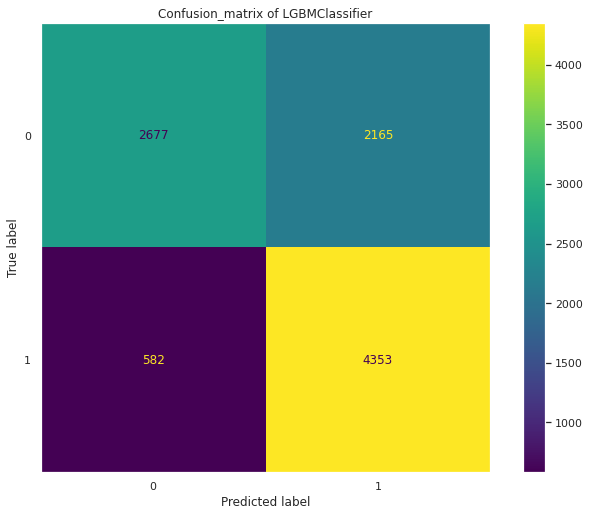

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
Model = LGBMClassifier(n_estimators = 135, tree_method = "gpu_hist", reg_alpha= 0.15, reg_lambda= 0.34)
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)
score = accuracy_score(y_test,y_pred)
print("LGBMClassifier: ",score)
plot_confusion_matrix(Model, X_test,y_test, values_format = '', )
plt.title("Confusion_matrix of LGBMClassifier")
plt.grid(False)
plt.show()

XGBClassifier:  0.7194435921039174


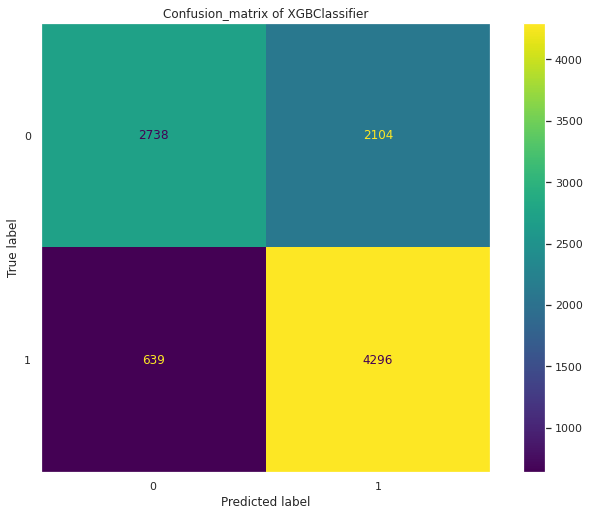

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
Model = XGBClassifier(n_estimators = 554, tree_method = "gpu_hist", max_depth=3, reg_alpha= 0.12, reg_lambda = 1)
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)
score = accuracy_score(y_test,y_pred)
print("XGBClassifier: ",score)
plot_confusion_matrix(Model, X_test,y_test, values_format = '')
plt.title("Confusion_matrix of XGBClassifier")
plt.grid(False)
plt.show()

# Result:

## **EDA:** 


1.   From Countplot we can see that the Given dataset is balanced. So we will use Accuracy as our evaluation matrix
2.   mentee_major has closed to 1800 missing values,mentor_major has closed to 1200 missing values, mentee_help_topics has closed to 16000 missing values, mentor_help_topics has closed to 1400 missing values
3.   Top 3 skills selected by mentees in college are: 1) Business administration 2) Computer networks and cybersecurity 3) Psychology
4.   Top 3 skills selected by mentors in college are: 1) Business administration 2) Computer networks and cybersecurity 3) Information system management
5.   Top 3 topics in which mentees are seeking help: 1) Career planning 2)  Career / industry trends 3) General networking
6.   Top 3 topics in which mentors are willing to help: 1) Leadership skills 2)  Career / industry trends 3) Management
7.   Top 3 domains in which mentees are looking to build
 expertise: 1) computer - it services 2)  Cybersecurity 3) Business services
8.   Top 3 domain in which mentors has expertise: 1) computer - it services 2)  government / public admin 3) Business services

## **Method_1: Using Word Mover’s Distance**
In this method we have performed the following steps:


1.   Pre_processing: Removing Stop words, Square brackets, single quotes, Converting into lowercase
2.   Creating Vocabulary from the given dataset and adding it to Word2vec models
3.   Feature Engineering: Getting the similarity Score between mentee & mentor using Word Mover’s Distance
4.   Handling the Infinity values
5.   Multicollinearity check
6.   Model selection via cross-validation: Best performing models using this method are
            XGBClassifier  -> CV_score = 0.667731
            LGBMClassifier -> CV_score = 0.647682




## **Method 2: Using pre_trained models(Hugging Face)**
In this method we have performed the following steps:


1.   Pre_processing: Removing Stop words, Square brackets, single quotes, Converting into lowercase
2.   Loading the pre_trained model
3.   Feature Engineering: Embedding & Cosine similarity
4.   Handling the Infinity values
5.   Multicollinearity check
6.   Model selection via cross-validation: Best performing models using this method are
            XGBClassifier          -> CV_score = 0.687615
            LGBMClassifier         -> CV_score = 0.701751
            RandomForestClassifier -> CV_score = 0.694693
**Note: Method 2 gives better performance. So we will use this method for Hyperparameter Tuning**

7.   Hyperparameter Tuning: After this step
            XGBClassifier          -> score = 0.7194
            LGBMClassifier         -> score = 0.7190
8.   Learning curve for Overfitting and Underfitting
            1.   As training set size increases testing accuracy increases. Therefore adding more data will increase the performance
            2.   Training accuracy is high, so our model has a low bias
            3.   Gap between the two curves indicates variance. Generally, the more narrow the gap, the lower the variance. 
            The opposite is also true: the wider the gap, the greater the variance. here we have a high variance
            4.  This high variance problem can be solved by adding more data, as we can see that, in the graph slope of 
            the test accuracy is more than train accuracy
            5.  Generally in low bias and high variance,  XGboost perform well